In [1]:
import warnings;warnings.filterwarnings('ignore')

import re
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

import lightgbm as lgb
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver3.csv'
test_path  = f'{data_path}/new/new_test_ver3.csv'

print(os.listdir(data_path))

['new', 'subway_feature.csv', 'train.csv', 'test.csv', 'bus_feature.csv', 'sample_submission.csv']


In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

Train data shape :  (1118822, 42) Test data shape :  (9272, 41)


In [4]:
# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
data = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

print(data.shape)

(1128094, 43)


In [5]:
data.columns

Index(['본번', '부번', '아파트명', '전용면적', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       '거래유형', '부동산유형', '분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-등록일자', 'k-수정일자', '경비비관리형태', '세대전기계약방법',
       '청소비관리형태', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target',
       '구', '동', '계약날짜', 'is_test'],
      dtype='object')

In [6]:
columns_to_drop = ['아파트명', '해제사유발생일', '등기신청일자', 'k-관리방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과',
                   'k-등록일자', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적',
                   'k-시행사']

data['본번'] = data['본번'].astype(int)
data['부번'] = data['부번'].astype(int)

df = data.drop(columns=columns_to_drop)

In [7]:
sample_data = df.sample(n=10000)
sample_data.to_csv("./sample_data.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 27 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   본번         1128094 non-null  int64  
 1   부번         1128094 non-null  int64  
 2   전용면적       1128094 non-null  float64
 3   층          1128094 non-null  int64  
 4   건축년도       1128094 non-null  int64  
 5   도로명        1128094 non-null  object 
 6   거래유형       1128094 non-null  object 
 7   부동산유형      1128094 non-null  object 
 8   분양형태       1128094 non-null  object 
 9   k-복도유형     1128094 non-null  object 
 10  k-난방방식     1128094 non-null  object 
 11  k-전체동수     250887 non-null   float64
 12  k-전체세대수    251969 non-null   float64
 13  k-건설사      1128094 non-null  object 
 14  k-연면적      251969 non-null   float64
 15  k-주거전용면적   251924 non-null   float64
 16  k-관리비부과면적  251969 non-null   float64
 17  주차대수       251817 non-null   float64
 18  단지승인일      251240 non-null   object 
 19  좌표X     

# 2.컬럼별 처리

## 2-1.본번

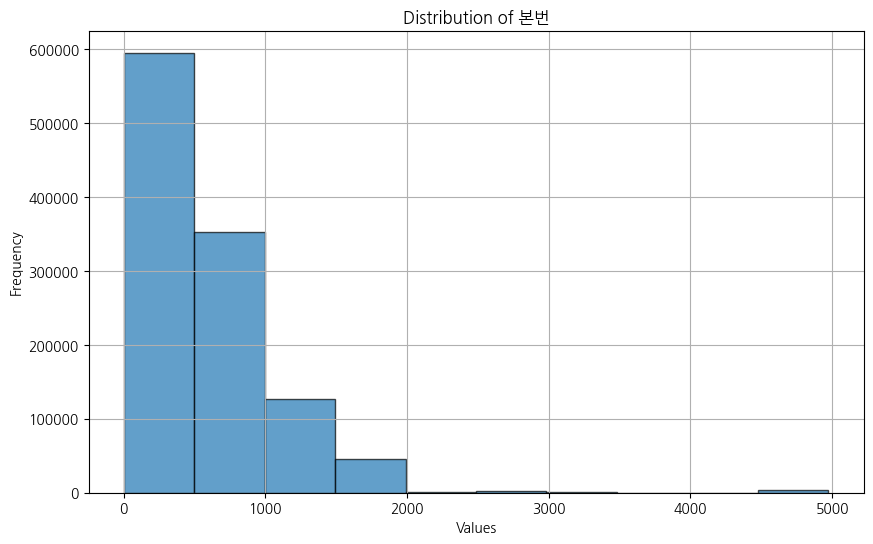

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

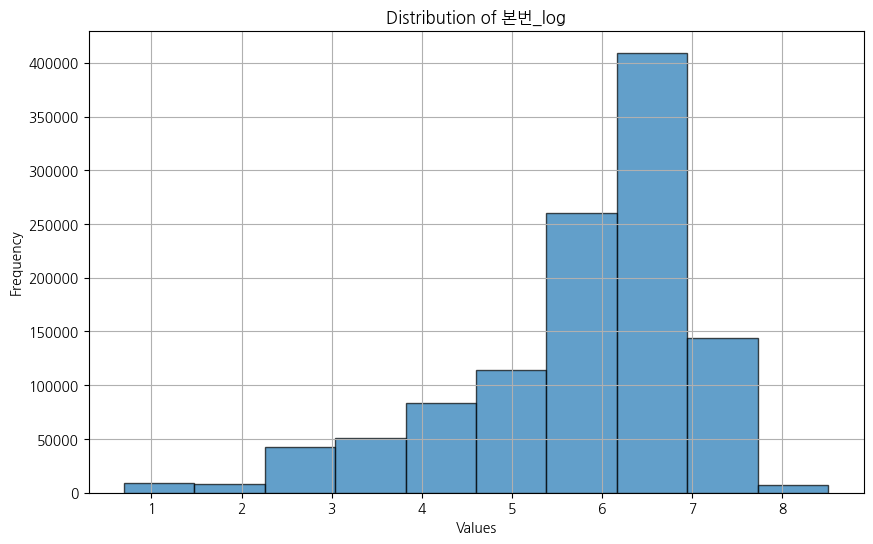

In [10]:
df['본번_log'] = np.log1p(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

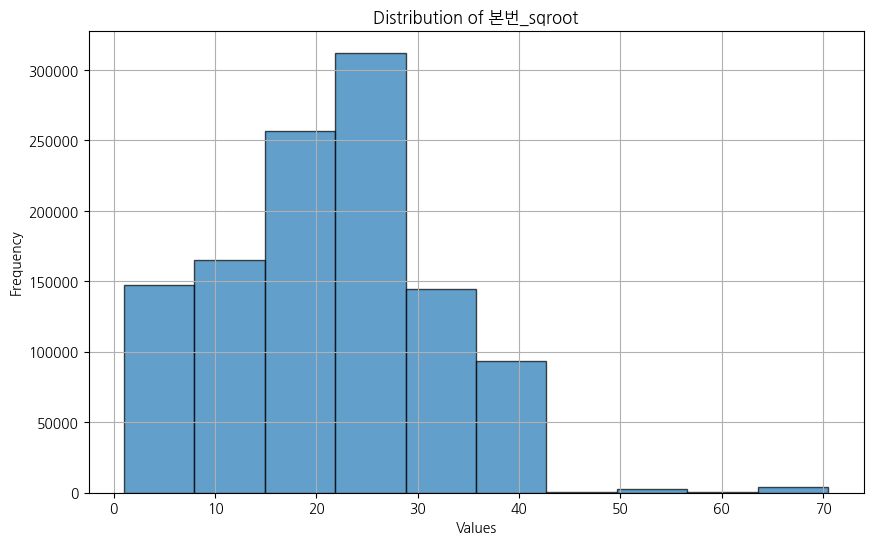

In [11]:
df['본번_sqroot'] = np.sqrt(df['본번'])

plt.figure(figsize=(10, 6))
plt.hist(df['본번_sqroot'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번_sqroot')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

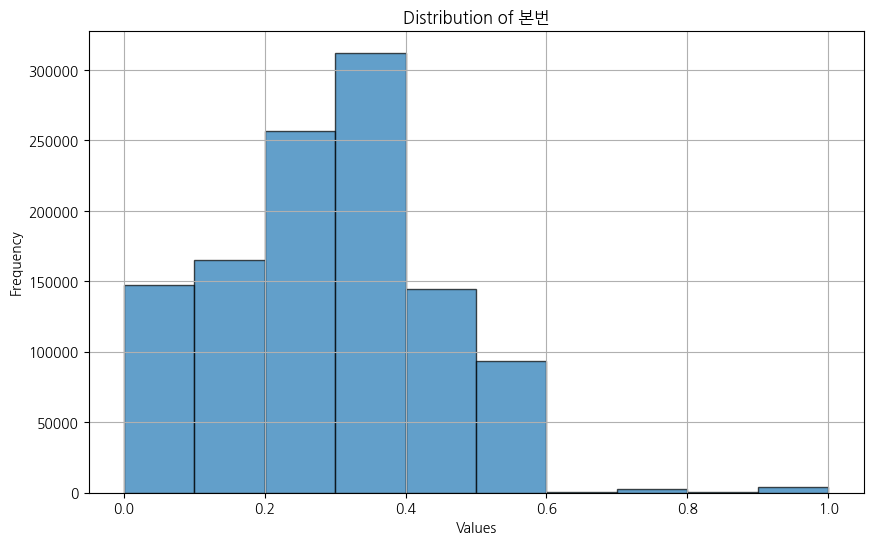

In [12]:
scaler = MinMaxScaler()
df['본번'] = scaler.fit_transform(df[['본번_sqroot']])

plt.figure(figsize=(10, 6))
plt.hist(df['본번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 본번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
df = df.drop(columns=['본번_log', '본번_sqroot'])
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       '계약날짜', 'is_test'],
      dtype='object')


## 2-2.부번

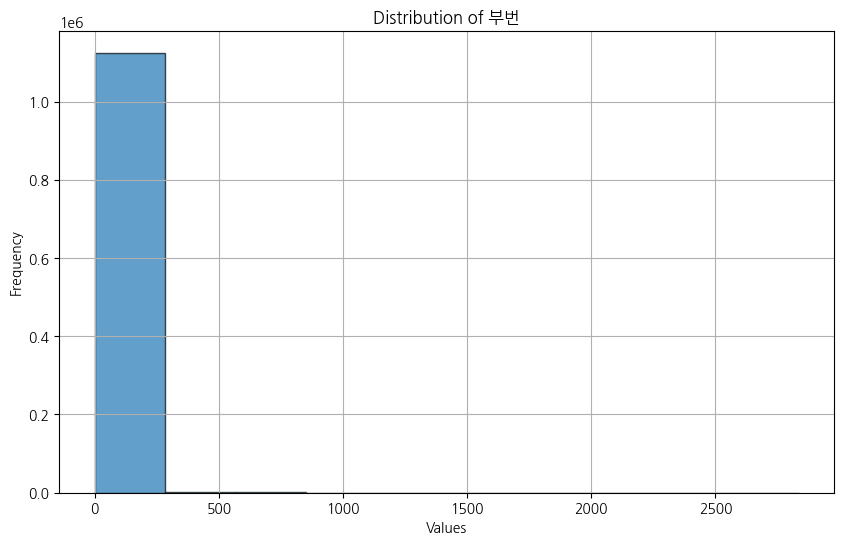

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

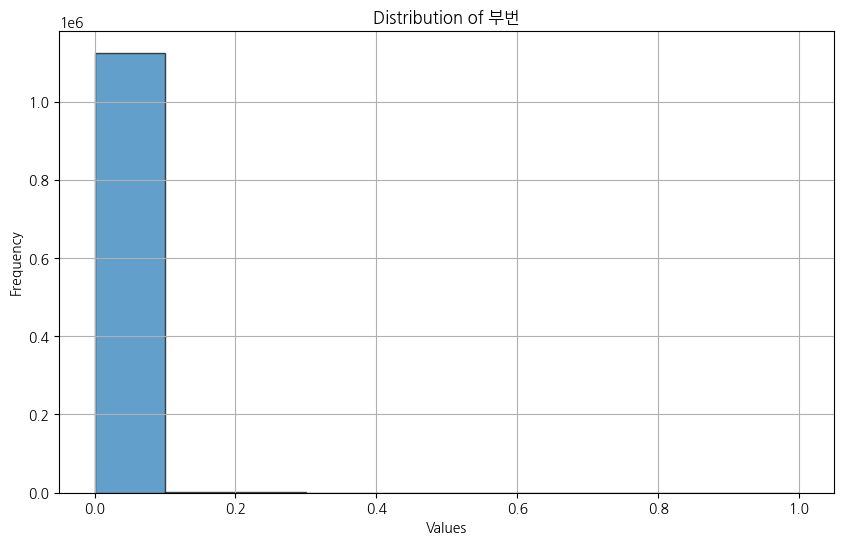

In [15]:
scaler = MinMaxScaler()
df['부번'] = scaler.fit_transform(df[['부번']])

plt.figure(figsize=(10, 6))
plt.hist(df['부번'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 부번')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-3.전용면적

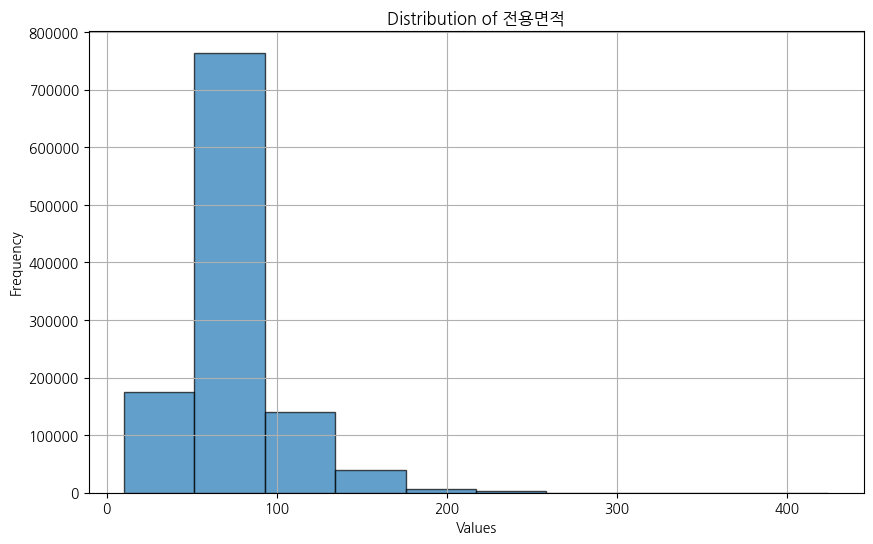

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

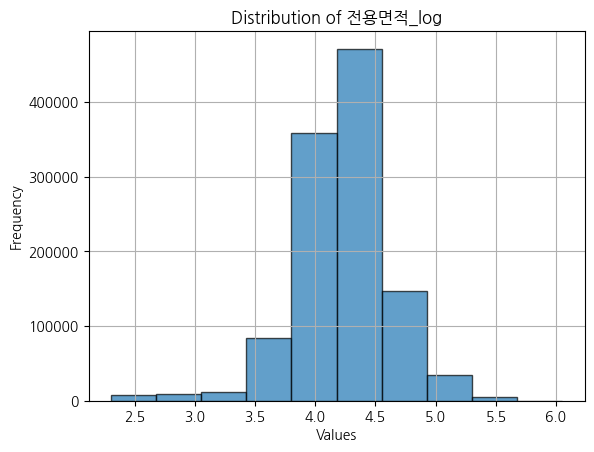

In [17]:
df['전용면적_log'] = np.log(df['전용면적'])

plt.hist(df['전용면적_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       '계약날짜', 'is_test', '전용면적_log'],
      dtype='object')


In [19]:
df = df.drop(columns=['전용면적_log'])
df['전용면적'] = np.log(df['전용면적'])
print(df.columns)

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       '계약날짜', 'is_test'],
      dtype='object')


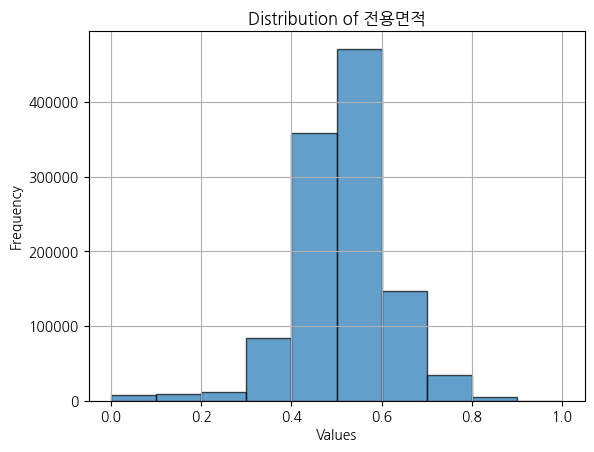

In [20]:
scaler = MinMaxScaler()
df['전용면적'] = scaler.fit_transform(df[['전용면적']])

plt.hist(df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-3.계약날짜

부동산 거래를 한 시점이므로 금리나 GDP와 같은 데이터와 연계하는데 사용가능할듯. 대신 추가 정보가 데이터프레임에 추가되고 나서는 삭제하거나 시계열로 다루는 기준이 될 뿐 학습에 직접적으로 반영되지는 않을듯

In [21]:
df['계약날짜'].info

<bound method Series.info of 0       2017-12-08
1       2017-12-22
2       2017-12-28
3       2018-01-03
4       2018-01-08
           ...    
9267    2023-07-19
9268    2023-07-25
9269    2023-08-27
9270    2023-09-02
9271    2023-09-04
Name: 계약날짜, Length: 1128094, dtype: object>

In [22]:
df['계약날짜'] = pd.to_datetime(df['계약날짜'], format='%Y-%m-%d')

In [23]:
df['계약날짜'].info

<bound method Series.info of 0      2017-12-08
1      2017-12-22
2      2017-12-28
3      2018-01-03
4      2018-01-08
          ...    
9267   2023-07-19
9268   2023-07-25
9269   2023-08-27
9270   2023-09-02
9271   2023-09-04
Name: 계약날짜, Length: 1128094, dtype: datetime64[ns]>

In [24]:
oldest_date = data['계약날짜'].min()
most_recent_date = data['계약날짜'].max()

print(oldest_date, most_recent_date)

2007-01-01 2023-09-26


In [25]:
base_date = base_date = pd.Timestamp('2006-12-31')
df['계약날짜_경과일'] = (df['계약날짜'] - base_date).dt.days
# df.drop(columns=['계약날짜'], inplace=True)

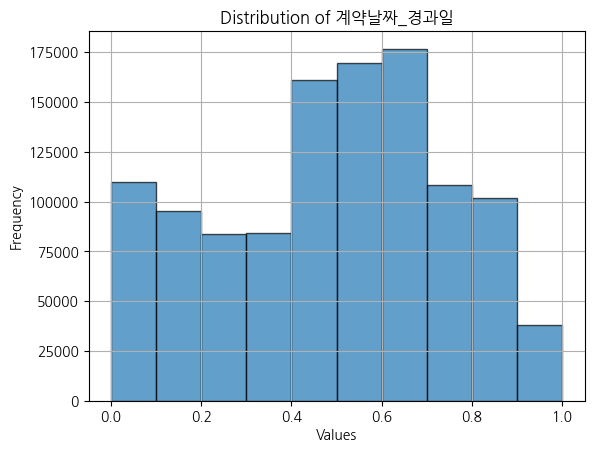

In [26]:
scaler = MinMaxScaler()
df['계약날짜_경과일'] = scaler.fit_transform(df[['계약날짜_경과일']])

plt.hist(df['계약날짜_경과일'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약날짜_경과일')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-4.층

In [27]:
print(df['층'].min(), df['층'].max())
print(df['층'].value_counts())

-4 69
층
 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 65        6
 67        6
 68        6
-4         4
 69        2
Name: count, Length: 73, dtype: int64


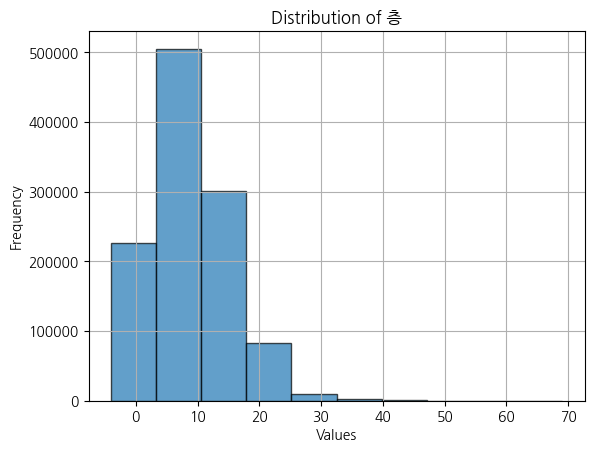

In [28]:
plt.hist(df['층'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

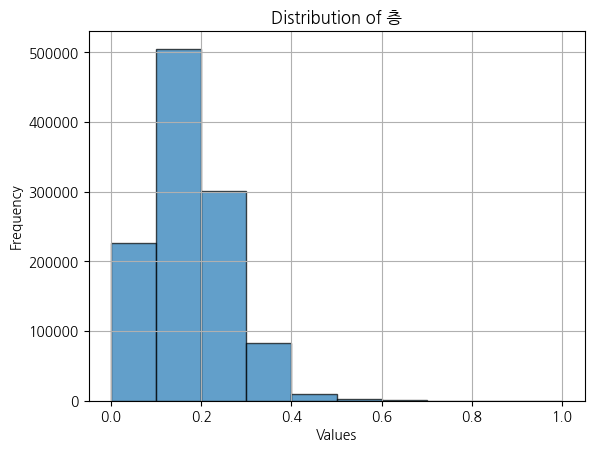

In [29]:
scaler = MinMaxScaler()
df['층'] = scaler.fit_transform(df[['층']])

plt.hist(df['층'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-5.k-건설사

In [30]:
print(len(df['k-건설사'].unique()))
print(list(df['k-건설사'].unique()))

193
['우성건설', '박연정', '대한주택공사', '현대건설', '동양고속건설주식회사', '대우건설', '대림산업', '삼성물산', 'unknown', '현대,쌍용,GS', '쌍용건설(주)', '한보건설', '삼성중공업', '대성산업', '중앙건설', '세방기업', '태영건설', '신동아건설', '고려개발(주)', '대우건설,대림산업,태영건설', '한라, 두진', '고려산업개발(주)', '롯데건설', 'GS건설', '한화건설', '한진중공업', '(주)건영,삼익주택,라이프주택', '계룡건설산업(주)', '한양건설', '건영', '청담삼익아파트', '계룡건설(주)', '삼환', 'KR산업', '동부건설', '고속도로관리공단', 'SH공사', '남광, 대우', '청광종합건설(주)', '중앙건설(주)', 'LG건설', '신동아건설(주)', '(주)청구주택', '삼호건설', '한솔건설', '현대,대림', '신동아 건설(주)', '임광건설', '벽산건설', '현대 성우건설', '홍익종합건업(주)', '성지건설', '남광토건(주)', '신명건설,신원건설,미주건설', 'KCC건설', '두산, 이수건설', '두산건설', 'TEC건설', '현대건설,현대산업개발,한진중공업', '성원건설', '라인건설', '코오롱건설', '금호', '(주)대보건설', '경남기업', '서광산업', '우림건설', '청구건설', '삼환, 삼익건설', '(주)쌍용건설', '보람건설(주)', '한일건설', '서희건설', '대호아이피종합건설', '라이프건설', '갑을건설', 'SK건설', '우성건설(주)', '고려산업개발', '인정건설', '(주)우성건설', '재건축조합', '(주)월드건설', '삼익건설', '우리건설', '대한전척(주)', '포스코건설', '풍림건설', '(주)중앙건설', '신도건설', '풍림산업,현대건설', '효성건설', '현대엔지니어링', '이수건설', '한일개발', '효성중공업', '두산건설주식회사', '세양건설', '인덕주택재건축정비사업조합/(주)신도종합건설', '롯데건설,우성

In [31]:
def split_builders(builders):
    # 여러 구분자를 처리하는 정규 표현식 패턴
    pattern = re.compile(r'[\/,\s]+')
    return pattern.split(builders.strip())

df['k-건설사'] = df['k-건설사'].apply(split_builders)
mlb = MultiLabelBinarizer()

df_encoded = pd.DataFrame(mlb.fit_transform(df['k-건설사']), columns=mlb.classes_, index=df.index)
df = df.join(df_encoded)

In [32]:
"(주)대림/ (주)삼성", "대림,삼성,현대,현산", "대우,럭키개발,롯데건설,선경건설,태평양건설", "대우건설,대림산업,태영건설", "롯데건설,우성건설", "미주실업,동방티앤씨", "삼성물산,한화건설", "인덕주택재건축정비사업조합/(주)신도종합건설", "포스코,SK,현대", "풍림산업,현대건설",
"현대 성우건설", "현대,대림", "현대,쌍용,GS", "현대건설,삼성물산,현대산업개발", "현대건설,현대산업개발,한진중공업"

for col in list(df.columns):
    print(col)

본번
부번
전용면적
층
건축년도
도로명
거래유형
부동산유형
분양형태
k-복도유형
k-난방방식
k-전체동수
k-전체세대수
k-건설사
k-연면적
k-주거전용면적
k-관리비부과면적
주차대수
단지승인일
좌표X
좌표Y
단지신청일
target
구
동
계약날짜
is_test
계약날짜_경과일
(주)
(주)건설알포메
(주)건영
(주)대림
(주)대보건설
(주)대우자동차판매
(주)도시공감
(주)삼성
(주)삼전건설
(주)순영종합건설
(주)신도종합건설
(주)신일건업
(주)쌍용건설
(주)우리창우
(주)우성건설
(주)월드건설
(주)중앙건설
(주)청구주택
(주)현진종합건설
BYC
GS
GS건설
JR건설
KCC건설
KR산업
LG건설
LIG건설
SH공사
SK
SK건설
TEC건설
unknown
갑을건설
건설(주)
건영
경남기업
경동건설
경향건설
계룡건설
계룡건설(주)
계룡건설산업(주)
고려개발
고려개발(주)
고려산업개발
고려산업개발(주)
고속도로관리공단
공영토건
극동건설
금하건설
금호
나산건설
남광
남광토건(주)
남해건설
대동건설
대림
대림산업
대명종합건설
대백건설
대성산업
대우
대우건설
대주건설
대창건설
대한전척(주)
대한주택공사
대호아이피종합건설
도시개발공사
돈암정릉구역주택재개발정비사업조합
동방티앤씨
동부건설
동선구역주택재개발조합
동성개발
동아건설
동양고속건설주식회사
동양메이저건설
동원산업건설
동일
동일토건
동일하이빌
두산
두산건설
두산건설(주)
두산건설주식회사
두진
라성건설
라이프건설
라이프주택
라인건설
럭키개발
롯데건설
문영건설
미원건설(주)
미주건설
미주실업
박연정
벽산건설
보람건설(주)
삼부토건
삼성
삼성물산
삼성중공업
삼익건설
삼익주택
삼정건설
삼중종합건설(주)
삼호건설
삼환
상부종합건설(주)
서광산업
서초건설
서희건설
선경
선경건설
성우건설
성원건설
성지건설
세방기업
세양건설
신도건설
신동아
신동아건설
신동아건설(주)
신명건설
신성건설
신영건설
신원건설
신창건설
신한건설
신홍선건설
쌍용
쌍용건설
쌍용건설(주)
아남건설주식회사
아키데코
양우건설
예성종합건설
우리건설
우림건설
우방건

## 2-6.부동산유형

In [33]:
le = LabelEncoder()
df['부동산유형'] = le.fit_transform(df['부동산유형'])

# 3.GDP 추가

In [34]:
kor_gdp = pd.read_csv(f"{data_path}/new/kor-gdp.csv")
kor_gdp.head()

,통계표,계정항목,단위,변환,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,9.1.4.2. 국제 주요국 국내총생산(GDP),한국,백만달러,원자료,"547,743.1","626,989.2","702,696.2","792,532.0","934,707.9","1,052,610.2",...,"1,484,488.5","1,466,038.9","1,499,679.8","1,623,074.1","1,725,373.4","1,651,422.9","1,644,312.8","1,818,432.2","1,673,916.5","1,712,792.9"


In [35]:
gdp_data_cleaned = kor_gdp.melt(id_vars=["통계표", "계정항목", "단위", "변환"], 
                                 var_name="Year", 
                                 value_name="GDP")
gdp_data_cleaned = gdp_data_cleaned[gdp_data_cleaned["계정항목"] == "한국"]
gdp_data_cleaned = gdp_data_cleaned[["Year", "GDP"]]
gdp_data_cleaned["Year"] = gdp_data_cleaned["Year"].astype(int)
gdp_data_cleaned["GDP"] = gdp_data_cleaned["GDP"].str.replace(',', '').astype(float)

df['계약날짜'] = pd.to_datetime(df['계약날짜'])
df['Year'] = df['계약날짜'].dt.year

df = pd.merge(df, gdp_data_cleaned, on='Year', how='left')
df = df.drop(columns=['Year'])

In [36]:
df.head()

,본번,부번,전용면적,층,건축년도,도로명,거래유형,부동산유형,분양형태,k-복도유형,...,현대힐스테이트,현산,혜림건설,호반건설,홍익종합건업(주),효성건설,효성중공업,흑석5구역재개발조합,흥화건설,GDP
0,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0,1623074.1
1,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0,1623074.1
2,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0,1623074.1
3,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0,1623074.1
4,0.354562,0.000352,0.454466,0.123288,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0,1623074.1


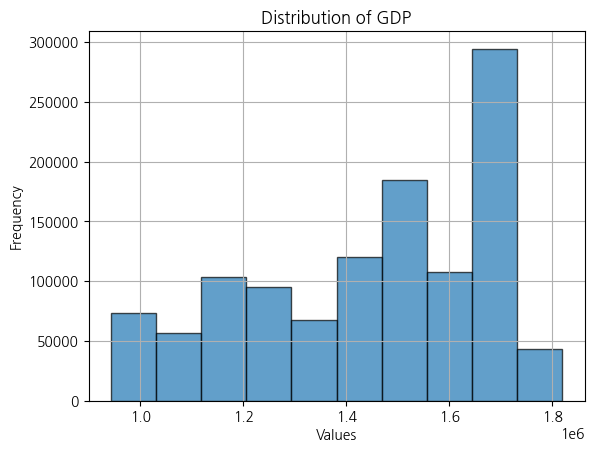

In [37]:
plt.hist(df['GDP'], edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

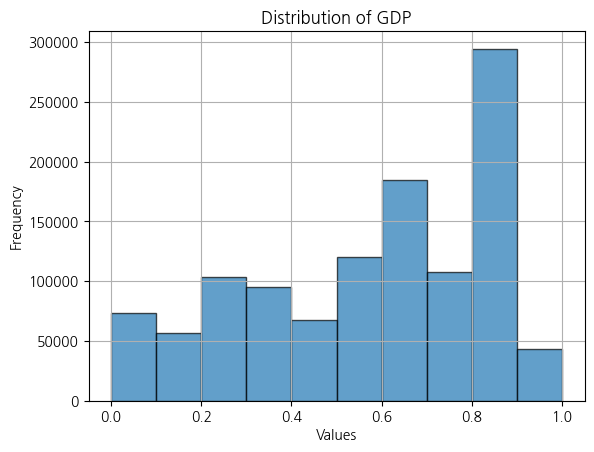

In [38]:
scaler = MinMaxScaler()
df['GDP'] = scaler.fit_transform(df[['GDP']])

plt.hist(df['GDP'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. 기준금리 추가

In [39]:
kor_ir = pd.read_csv(f"{data_path}/new/kor-ir.csv")
kor_ir.head()

,Interest Rate Type,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,기준금리,5.0,3.0,2.0,2.5,3.25,2.75,2.5,2.0,1.5,1.25,1.5,1.75,1.25,0.5,1.0,3.25,3.5


In [40]:
df['계약연도'] = pd.to_datetime(df['계약날짜']).dt.year
df['계약연도'] = df['계약연도'].astype(int)

interest_rate_data_transposed = kor_ir.set_index('Interest Rate Type').T
interest_rate_data_transposed.index = interest_rate_data_transposed.index.astype(int)

df['IR'] = df['계약연도'].map(interest_rate_data_transposed['기준금리'])
df = df.drop(columns=['계약연도'])

In [41]:
df.head()

,본번,부번,전용면적,층,건축년도,도로명,거래유형,부동산유형,분양형태,k-복도유형,...,현산,혜림건설,호반건설,홍익종합건업(주),효성건설,효성중공업,흑석5구역재개발조합,흥화건설,GDP,IR
0,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0.776663,1.5
1,0.354562,0.000352,0.554490,0.095890,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0.776663,1.5
2,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0.776663,1.5
3,0.354562,0.000352,0.554490,0.109589,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0.776663,1.5
4,0.354562,0.000352,0.454466,0.123288,1987,언주로 3,-,3,분양,계단식,...,0,0,0,0,0,0,0,0,0.776663,1.5


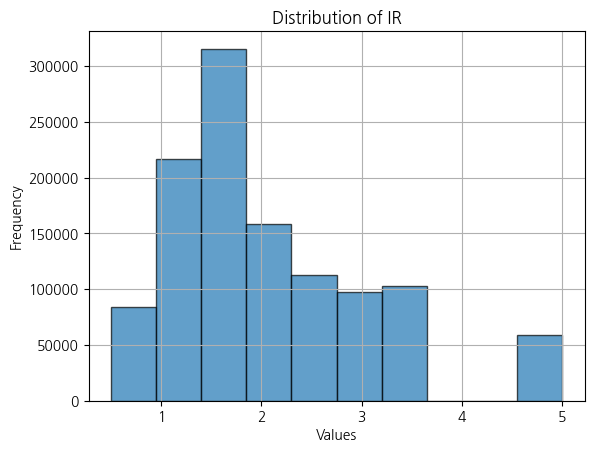

In [42]:
plt.hist(df['IR'], edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

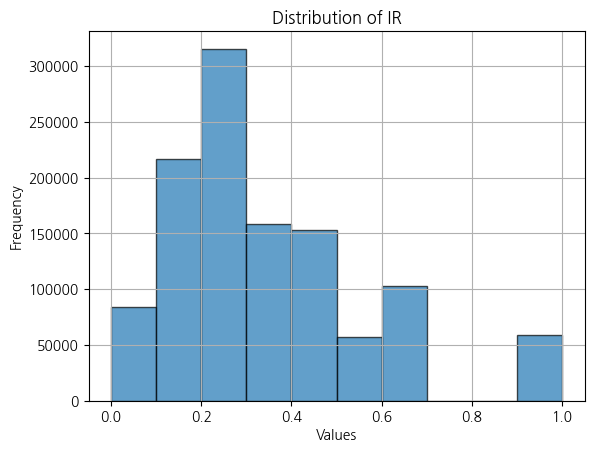

In [43]:
scaler = MinMaxScaler()
df['IR'] = scaler.fit_transform(df[['IR']])

plt.hist(df['IR'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 5.결측치 예측 모델

In [44]:
df.columns

Index(['본번', '부번', '전용면적', '층', '건축년도', '도로명', '거래유형', '부동산유형', '분양형태',
       'k-복도유형',
       ...
       '현산', '혜림건설', '호반건설', '홍익종합건업(주)', '효성건설', '효성중공업', '흑석5구역재개발조합',
       '흥화건설', 'GDP', 'IR'],
      dtype='object', length=230)

In [45]:
curr_df = df.dropna(subset=['k-연면적'])
print(curr_df.shape)

train_df = curr_df[curr_df['is_test'] == 0]
test_df = curr_df[curr_df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
# test_df = test_df.drop(columns=['is_test', 'target'])
test_df = df[df['k-연면적'].isna()]

print(train_df.shape, test_df.shape)

(257201, 230)
(251781, 229) (889437, 230)


In [46]:
X = train_df.drop(columns=['k-연면적'])
y = train_df['k-연면적']

X_test = test_df.drop(columns=['k-연면적'])

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [49]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: 도로명: object, 거래유형: object, 분양형태: object, k-복도유형: object, k-난방방식: object, k-건설사: object, 단지승인일: object, 단지신청일: object, 구: object, 동: object, 계약날짜: datetime64[ns]

In [ ]:
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")

In [ ]:
test_predictions = model.predict(X_test, num_iteration=model.best_iteration)